In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import expit

from treepleeeeeeeeee import RandomForestClassifier, RandomForestRegressor
from treepleeeeeeeeee.stats import (
    FeatureImportanceForestClassifier,
    FeatureImportanceForestRegressor,
    PermutationForestRegressor,
)

seed = 12345

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def linear_model_ancova(
    sigma_factor=2.0, seed=None, permute_per_tree=True, sample_dataset_per_tree=True
):
    r"""Test MIGHT using MSE from linear model simulation.

    See https://arxiv.org/pdf/1904.07830.pdf Figure 1.

    Y = Beta * X_1 + Beta * I(X_6 = 2) + \epsilon
    """
    beta = 10.0
    sigma = 10.0 / sigma_factor
    n_samples = 2200
    n_estimators = 500
    test_size = 0.1
    n_repeats = 1000
    metric = "mse"

    rng = np.random.default_rng(seed)

    # sample covariates
    X_15 = rng.uniform(0, 1, size=(n_samples, 5))
    X_610 = np.zeros((n_samples, 5))
    for idx in range(5):
        buff = np.argwhere(
            rng.multinomial(1, [1.0 / 3, 1.0 / 3, 1.0 / 3], size=n_samples)
        )[:, 1]

        X_610[:, idx] = buff

    X = np.concatenate((X_15, X_610), axis=1)
    assert X_15.shape == (n_samples, 5)
    assert X_610.shape == (n_samples, 5)
    assert X.shape == (n_samples, 10)

    # sample noise
    epsilon = rng.normal(size=n_samples, loc=0.0, scale=sigma)

    # compute final y of (n_samples,)
    y = beta * X[:, 0] + (beta * (X[:, 5] - 2)) + epsilon

    # initialize hypothesis tester
    est = FeatureImportanceForestRegressor(
        RandomForestRegressor(
            max_features=1.0, random_state=seed, n_estimators=n_estimators, n_jobs=-1
        ),
        test_size=test_size,
        random_state=seed,
        permute_per_tree=permute_per_tree,
        sample_dataset_per_tree=sample_dataset_per_tree,
    )
    pvalue_dict = {}

    # test for X_1
    stat, pvalue = est.test(X.copy(), y.copy(), [0], metric=metric, n_repeats=n_repeats)
    print("X1: ", pvalue)
    pvalue_dict["X1"] = pvalue
    # assert pvalue < 0.05, f"pvalue: {pvalue}"

    # test for X_6
    stat, pvalue = est.test(X.copy(), y.copy(), [5], metric=metric, n_repeats=n_repeats)
    print("X6: ", pvalue)
    pvalue_dict["X6"] = pvalue
    # assert pvalue < 0.05, f"pvalue: {pvalue}"

    # test for a few unimportant other X
    for name, covariate_index in zip(["X2", "X7"], [1, 6]):
        # test for X_2, X_7
        stat, pvalue = est.test(
            X.copy(),
            y.copy(),
            [covariate_index],
            metric=metric,
            n_repeats=n_repeats,
        )
        print("X2/7: ", pvalue)
        pvalue_dict[name] = pvalue
        # assert pvalue > 0.05, f"pvalue: {pvalue}"

    return pvalue_dict


def linear_model_mars():
    pass


def random_forest_model():
    pass

In [12]:
def correlated_logit_model(
    beta=5.0, seed=None, permute_per_tree=True, sample_dataset_per_tree=True
):
    r"""Test MIGHT using MSE from linear model simulation.

    See https://arxiv.org/pdf/1904.07830.pdf Figure 1.

    P(Y = 1 | X) = expit(beta * \\sum_{j=2}^5 X_j)
    """
    n_samples = 600
    n_estimators = 125
    n_jobs = -1
    max_features = "sqrt"
    test_size = 1.0 / 6
    metric = "mse"
    n_repeats = 500

    n = 500  # Number of time steps
    ar_coefficient = 0.15

    rng = np.random.default_rng(seed)

    X = np.zeros((n_samples, n))
    for idx in range(n_samples):
        # sample covariates
        white_noise = rng.standard_normal(size=n)

        # Create an array to store the simulated AR(1) time series
        ar1_series = np.zeros(n)
        ar1_series[0] = white_noise[0]

        # Simulate the AR(1) process
        for t in range(1, n):
            ar1_series[t] = ar_coefficient * ar1_series[t - 1] + white_noise[t]

        X[idx, :] = ar1_series

    # now compute the output labels
    y_proba = expit(beta * X[:, 1:5].sum(axis=1))
    assert y_proba.shape == (n_samples,)
    y = rng.binomial(1, y_proba, size=n_samples)  # .reshape(-1, 1)

    pvalue_dict = {}

    # initialize hypothesis tester
    est = FeatureImportanceForestClassifier(
        RandomForestClassifier(
            max_features=1.0,
            random_state=seed,
            n_estimators=n_estimators,
            n_jobs=-1,
        ),
        random_state=seed,
        test_size=test_size,
        permute_per_tree=permute_per_tree,
        sample_dataset_per_tree=sample_dataset_per_tree,
    )

    # test for X_2 important
    stat, pvalue = est.test(
        X.copy(),
        y.copy(),
        covariate_index=[1],
        n_repeats=n_repeats,
        metric=metric,
    )
    pvalue_dict["X2"] = pvalue
    print("X2: ", pvalue)
    # assert pvalue < 0.05, f"pvalue: {pvalue}"

    # test for X_1 unimportant
    stat, pvalue = est.test(X.copy(), y.copy(), [0], n_repeats=n_repeats, metric=metric)
    pvalue_dict["X1"] = pvalue
    print("X1: ", pvalue)
    # assert pvalue > 0.05, f"pvalue: {pvalue}"

    # test for X_500 unimportant
    stat, pvalue = est.test(
        X.copy(),
        y.copy(),
        [n - 1],
        n_repeats=n_repeats,
        metric=metric,
    )
    pvalue_dict["X500"] = pvalue
    print("X500: ", pvalue)
    # assert pvalue > 0.05, f"pvalue: {pvalue}"
    return pvalue_dict

# Run Experiment on Linear ANCOVA Model

In [5]:
pvalue_dict = defaultdict(list)
rng = np.random.default_rng(seed)

j_space = np.linspace(0.005, 2.25, 9)

for sigma_factor in j_space:
    for idx in range(5):
        new_seed = rng.integers(0, np.iinfo(np.uint32).max, dtype=np.uint32)

        elements_dict = linear_model_ancova(
            sigma_factor,
            new_seed,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )
        for key, value in elements_dict.items():
            pvalue_dict[key].append(value)
        pvalue_dict["sigma_factor"].append(sigma_factor)

df = pd.DataFrame(pvalue_dict)

/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.7062937062937062


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.45054945054945056


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.7882117882117882


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.8221778221778222


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.025974025974025976


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.43156843156843155


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.13486513486513488


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.6093906093906094


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.995004995004995


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.5454545454545454


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.5254745254745254


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.33466533466533466


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.14985014985014986


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.09290709290709291


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.14485514485514486


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.46353646353646355


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.974025974025974


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.16083916083916083


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.056943056943056944


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.7652347652347652


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.11688311688311688


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.5484515484515484


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.06493506493506493


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.01898101898101898


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.6413586413586414


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.37662337662337664


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  1.0


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.8071928071928072


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.13986013986013987


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.03296703296703297


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.04695304695304695


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.17182817182817184


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.14985014985014986


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.11388611388611389


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.5204795204795205


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.04695304695304695


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.15084915084915085


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.24175824175824176


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.7952047952047953


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.9760239760239761


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.3086913086913087


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.013986013986013986


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.5974025974025974


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.4385614385614386


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  1.0


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.6953046953046953


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.8371628371628371


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.4875124875124875


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.4775224775224775


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.05194805194805195


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.26373626373626374


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.7502497502497503


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  1.0


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.983016983016983


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.3166833166833167


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.3276723276723277


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.8411588411588412


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.6023976023976024


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.984015984015984


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.3726273726273726


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.6663336663336663


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.7042957042957043


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.8691308691308691


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.11788211788211789


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.24475524475524477


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.6123876123876124


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.004995004995004995


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.6123876123876124


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.01898101898101898


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.1038961038961039


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.01998001998001998


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.939060939060939


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.26173826173826176


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.21678321678321677


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.3866133866133866


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.22677322677322678


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.32167832167832167


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.23476523476523475


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.001998001998001998


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.43956043956043955


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.04295704295704296


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.961038961038961


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.8261738261738262


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.14385614385614387


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.01898101898101898


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.015984015984015984


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.7162837162837162


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.2967032967032967


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.04095904095904096


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.07892107892107893


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.5284715284715285


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.7002997002997003


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  1.0


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.6843156843156843


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.001998001998001998


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.5024975024975025


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.5684315684315684


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.8381618381618382


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.8621378621378621


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.14985014985014986


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.965034965034965


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.03296703296703297


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.4195804195804196


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X1:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X6:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.000999000999000999


/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


X2/7:  0.3386613386613387


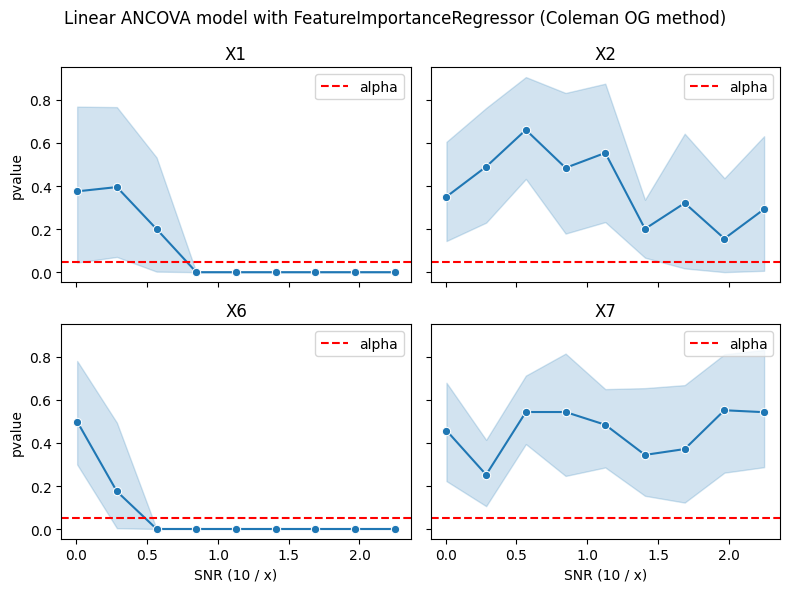

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharey=True, sharex=True)
axs = axs.flatten()

for ax, name in zip(axs, ["X1", "X2", "X6", "X7"]):
    sns.lineplot(data=df, x="sigma_factor", y=name, ax=ax, marker="o")

    ax.axhline([0.05], ls="--", color="red", label="alpha")
    ax.set(title=name, ylabel="pvalue", xlabel="SNR (10 / x)")
    ax.legend()
fig.suptitle("Linear ANCOVA model with FeatureImportanceRegressor (Coleman OG method)")
fig.tight_layout()

In [7]:
pvalue_dict = defaultdict(list)
rng = np.random.default_rng(seed)

j_space = np.linspace(0.005, 2.25, 9)

for sigma_factor in j_space:
    for idx in range(5):
        new_seed = rng.integers(0, np.iinfo(np.uint32).max, dtype=np.uint32)

        elements_dict = linear_model_ancova(
            sigma_factor,
            new_seed,
            permute_per_tree=True,
            sample_dataset_per_tree=True,
        )
        for key, value in elements_dict.items():
            pvalue_dict[key].append(value)
        pvalue_dict["sigma_factor"].append(sigma_factor)

df = pd.DataFrame(pvalue_dict)

X1:  0.000999000999000999
X6:  0.001998001998001998
X2/7:  0.000999000999000999
X2/7:  0.013986013986013986
X1:  0.3786213786213786
X6:  0.007992007992007992
X2/7:  0.24875124875124874
X2/7:  0.000999000999000999
X1:  0.3096903096903097
X6:  0.01898101898101898
X2/7:  0.013986013986013986
X2/7:  0.012987012987012988
X1:  0.005994005994005994
X6:  0.001998001998001998
X2/7:  0.022977022977022976
X2/7:  0.004995004995004995
X1:  0.33166833166833165
X6:  0.052947052947052944
X2/7:  0.06593406593406594
X2/7:  0.004995004995004995
X1:  0.07892107892107893
X6:  0.000999000999000999
X2/7:  0.23776223776223776
X2/7:  0.002997002997002997
X1:  0.003996003996003996
X6:  0.000999000999000999
X2/7:  0.15884115884115885
X2/7:  0.003996003996003996
X1:  0.24575424575424576
X6:  0.000999000999000999
X2/7:  0.5224775224775224
X2/7:  0.00999000999000999
X1:  0.008991008991008992
X6:  0.000999000999000999
X2/7:  0.03896103896103896
X2/7:  0.002997002997002997
X1:  0.000999000999000999
X6:  0.00099900099

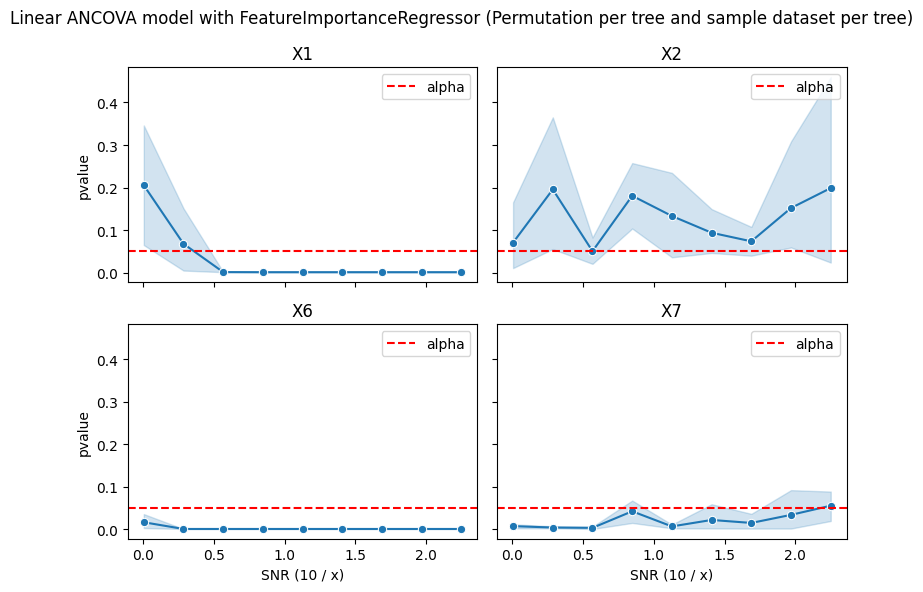

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharey=True, sharex=True)
axs = axs.flatten()

for ax, name in zip(axs, ["X1", "X2", "X6", "X7"]):
    sns.lineplot(data=df, x="sigma_factor", y=name, ax=ax, marker="o")

    ax.axhline([0.05], ls="--", color="red", label="alpha")
    ax.set(title=name, ylabel="pvalue", xlabel="SNR (10 / x)")
    ax.legend()
fig.suptitle(
    "Linear ANCOVA model with FeatureImportanceRegressor (Permutation per tree and sample dataset per tree)"
)
fig.tight_layout()

In [9]:
pvalue_dict = defaultdict(list)
rng = np.random.default_rng(seed)

j_space = np.linspace(0.005, 2.25, 9)

for sigma_factor in j_space:
    for idx in range(5):
        new_seed = rng.integers(0, np.iinfo(np.uint32).max, dtype=np.uint32)

        elements_dict = linear_model_ancova(
            sigma_factor,
            new_seed,
            permute_per_tree=True,
            sample_dataset_per_tree=False,
        )
        for key, value in elements_dict.items():
            pvalue_dict[key].append(value)
        pvalue_dict["sigma_factor"].append(sigma_factor)

df = pd.DataFrame(pvalue_dict)

X1:  1.0
X6:  0.4675324675324675
X2/7:  0.935064935064935
X2/7:  0.2817182817182817
X1:  0.22977022977022976
X6:  0.3676323676323676
X2/7:  1.0
X2/7:  0.28771228771228774
X1:  0.968031968031968
X6:  0.13786213786213786
X2/7:  0.7272727272727273
X2/7:  0.059940059940059943
X1:  1.0
X6:  0.9050949050949051
X2/7:  0.99000999000999
X2/7:  0.9100899100899101
X1:  0.21578421578421578
X6:  0.2017982017982018
X2/7:  0.0989010989010989
X2/7:  0.1998001998001998
X1:  1.0
X6:  0.03396603396603397
X2/7:  0.999000999000999
X2/7:  0.8891108891108891
X1:  1.0
X6:  0.000999000999000999
X2/7:  1.0
X2/7:  0.994005994005994
X1:  0.997002997002997
X6:  0.8231768231768232
X2/7:  1.0
X2/7:  0.5964035964035964
X1:  1.0
X6:  0.23276723276723277
X2/7:  0.993006993006993
X2/7:  0.23976023976023977
X1:  0.20679320679320679
X6:  0.000999000999000999
X2/7:  0.999000999000999
X2/7:  0.48451548451548454
X1:  0.000999000999000999
X6:  0.000999000999000999
X2/7:  0.942057942057942
X2/7:  0.061938061938061936
X1:  0.01

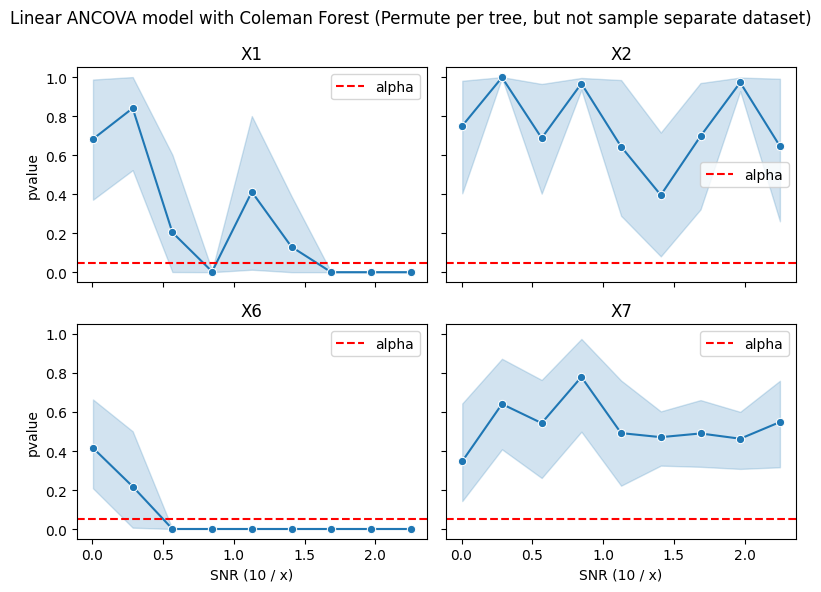

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharey=True, sharex=True)
axs = axs.flatten()

for ax, name in zip(axs, ["X1", "X2", "X6", "X7"]):
    sns.lineplot(data=df, x="sigma_factor", y=name, ax=ax, marker="o")

    ax.axhline([0.05], ls="--", color="red", label="alpha")
    ax.set(title=name, ylabel="pvalue", xlabel="SNR (10 / x)")
    ax.legend()
fig.suptitle(
    "Linear ANCOVA model with Coleman Forest (Permute per tree, but not sample separate dataset)"
)
fig.tight_layout()

# Run Experiment on Correlated Logit Model

In [11]:
j_space = np.linspace(0.005, 2.25, 9)
print(j_space)

[0.005    0.285625 0.56625  0.846875 1.1275   1.408125 1.68875  1.969375
 2.25    ]


In [13]:
pvalue_dict = defaultdict(list)
rng = np.random.default_rng(seed)

beta_space = np.hstack((np.linspace(0.01, 2.5, 8), np.linspace(5, 20, 7)))
# beta_space = j_space.copy()
for beta in beta_space:
    for idx in range(5):
        new_seed = rng.integers(0, np.iinfo(np.uint32).max, dtype=np.uint32)

        elements_dict = correlated_logit_model(
            beta, new_seed, permute_per_tree=False, sample_dataset_per_tree=False
        )
        for key, value in elements_dict.items():
            pvalue_dict[key].append(value)
        pvalue_dict["sigma_factor"].append(beta)

df = pd.DataFrame(pvalue_dict)

X2:  0.3912175648702595
X1:  0.4111776447105788
X500:  0.3872255489021956
X2:  0.3273453093812375
X1:  0.3273453093812375
X500:  0.29740518962075846
X2:  0.32934131736526945
X1:  0.36327345309381237
X500:  0.40119760479041916
X2:  0.3972055888223553
X1:  0.4550898203592814
X500:  0.36926147704590817
X2:  0.30538922155688625
X1:  0.27944111776447106
X500:  0.33532934131736525
X2:  0.4311377245508982
X1:  0.40119760479041916
X500:  0.3712574850299401
X2:  0.17964071856287425
X1:  0.3473053892215569
X500:  0.36127744510978044
X2:  0.3532934131736527
X1:  0.40718562874251496
X500:  0.4031936127744511
X2:  0.2554890219560878
X1:  0.4031936127744511
X500:  0.4111776447105788
X2:  0.5349301397205589
X1:  0.34530938123752497
X500:  0.35528942115768464
X2:  0.249500998003992
X1:  0.3992015968063872
X500:  0.3852295409181637
X2:  0.05189620758483034
X1:  0.3473053892215569
X500:  0.33532934131736525
X2:  0.0499001996007984
X1:  0.3333333333333333
X500:  0.4171656686626746
X2:  0.0039920159680638

In [14]:
print("done")

done


In [15]:
display(df.head())

,X2,X1,X500,sigma_factor
0,0.391218,0.411178,0.387226,0.01
1,0.327345,0.327345,0.297405,0.01
2,0.329341,0.363273,0.401198,0.01
3,0.397206,0.455090,0.369261,0.01
4,0.305389,0.279441,0.335329,0.01


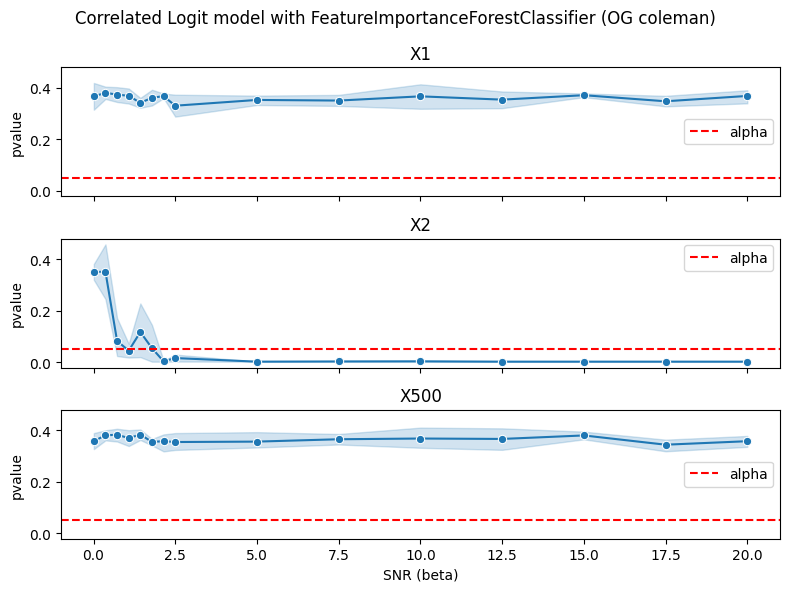

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharey=True, sharex=True)
axs = axs.flatten()

for ax, name in zip(axs, ["X1", "X2", "X500"]):
    sns.lineplot(data=df, x="sigma_factor", y=name, ax=ax, marker="o")

    ax.axhline([0.05], ls="--", color="red", label="alpha")
    ax.set(title=name, ylabel="pvalue", xlabel="SNR (beta)")
    ax.legend()
fig.suptitle(
    "Correlated Logit model with FeatureImportanceForestClassifier (OG coleman)"
)
fig.tight_layout()

In [17]:
pvalue_dict = defaultdict(list)
rng = np.random.default_rng(seed)

beta_space = np.hstack((np.linspace(0.01, 2.5, 8), np.linspace(5, 20, 7)))
# beta_space = j_space.copy()
for beta in beta_space:
    for idx in range(5):
        new_seed = rng.integers(0, np.iinfo(np.uint32).max, dtype=np.uint32)

        elements_dict = correlated_logit_model(
            beta, new_seed, permute_per_tree=True, sample_dataset_per_tree=True
        )
        for key, value in elements_dict.items():
            pvalue_dict[key].append(value)
        pvalue_dict["sigma_factor"].append(beta)

df = pd.DataFrame(pvalue_dict)

X2:  0.007984031936127744
X1:  0.00998003992015968
X500:  0.00998003992015968
X2:  0.00998003992015968
X1:  0.013972055888223553
X500:  0.00998003992015968
X2:  0.017964071856287425
X1:  0.027944111776447105
X500:  0.01996007984031936
X2:  0.005988023952095809
X1:  0.007984031936127744
X500:  0.00998003992015968
X2:  0.005988023952095809
X1:  0.003992015968063872
X500:  0.00998003992015968
X2:  0.001996007984031936
X1:  0.003992015968063872
X500:  0.00998003992015968
X2:  0.001996007984031936
X1:  0.005988023952095809
X500:  0.005988023952095809
X2:  0.013972055888223553
X1:  0.023952095808383235
X500:  0.00998003992015968
X2:  0.011976047904191617
X1:  0.01996007984031936
X500:  0.015968063872255488
X2:  0.007984031936127744
X1:  0.007984031936127744
X500:  0.011976047904191617
X2:  0.013972055888223553
X1:  0.013972055888223553
X500:  0.011976047904191617
X2:  0.005988023952095809
X1:  0.013972055888223553
X500:  0.017964071856287425
X2:  0.001996007984031936
X1:  0.00798403193612774

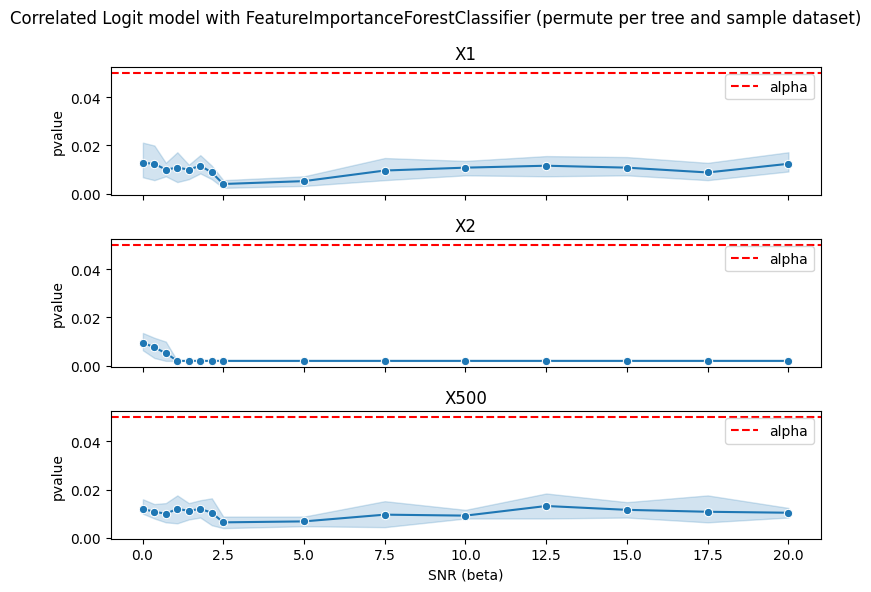

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharey=True, sharex=True)
axs = axs.flatten()

for ax, name in zip(axs, ["X1", "X2", "X500"]):
    sns.lineplot(data=df, x="sigma_factor", y=name, ax=ax, marker="o")

    ax.axhline([0.05], ls="--", color="red", label="alpha")
    ax.set(title=name, ylabel="pvalue", xlabel="SNR (beta)")
    ax.legend()
fig.suptitle(
    "Correlated Logit model with FeatureImportanceForestClassifier (permute per tree and sample dataset)"
)
fig.tight_layout()

In [20]:
pvalue_dict = defaultdict(list)
rng = np.random.default_rng(seed)

beta_space = np.hstack((np.linspace(0.01, 2.5, 8), np.linspace(5, 20, 7)))
# beta_space = j_space.copy()
for beta in beta_space:
    for idx in range(5):
        new_seed = rng.integers(0, np.iinfo(np.uint32).max, dtype=np.uint32)

        elements_dict = correlated_logit_model(
            beta, new_seed, permute_per_tree=True, sample_dataset_per_tree=False
        )
        for key, value in elements_dict.items():
            pvalue_dict[key].append(value)
        pvalue_dict["sigma_factor"].append(beta)

df = pd.DataFrame(pvalue_dict)

X2:  0.3912175648702595
X1:  0.44510978043912175
X500:  0.31137724550898205
X2:  0.29141716566866266
X1:  0.35528942115768464
X500:  0.36726546906187624
X2:  0.31137724550898205
X1:  0.3393213572854291
X500:  0.3972055888223553
X2:  0.3812375249500998
X1:  0.47105788423153694
X500:  0.45708582834331335
X2:  0.32934131736526945
X1:  0.2834331337325349
X500:  0.32934131736526945
X2:  0.4091816367265469
X1:  0.3932135728542914
X500:  0.2754491017964072
X2:  0.15768463073852296
X1:  0.3592814371257485
X500:  0.405189620758483
X2:  0.38922155688622756
X1:  0.39520958083832336
X500:  0.40119760479041916
X2:  0.23353293413173654
X1:  0.3413173652694611
X500:  0.3213572854291417
X2:  0.5289421157684631
X1:  0.32934131736526945
X500:  0.3652694610778443
X2:  0.24151696606786427
X1:  0.3772455089820359
X500:  0.3812375249500998
X2:  0.06986027944111776
X1:  0.31736526946107785
X500:  0.36327345309381237
X2:  0.05788423153692615
X1:  0.43912175648702595
X500:  0.38922155688622756
X2:  0.003992015

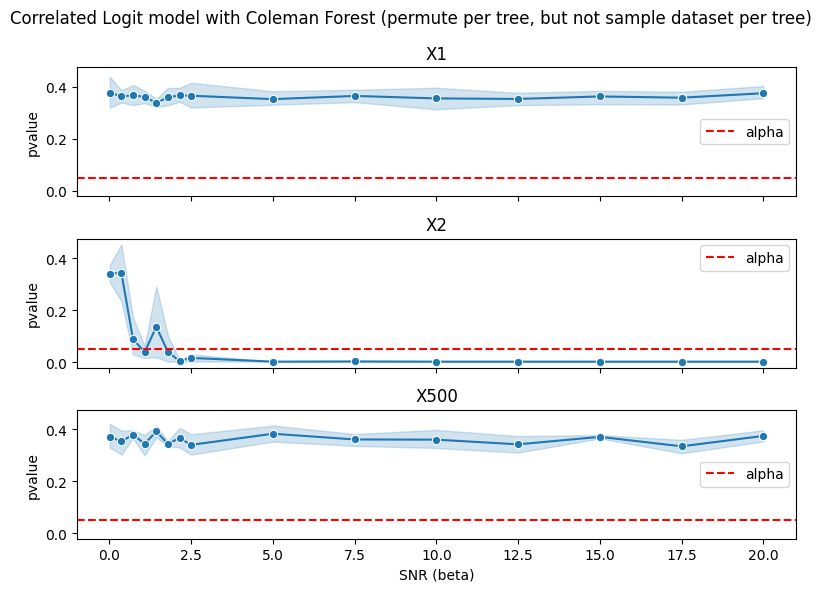

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharey=True, sharex=True)
axs = axs.flatten()

for ax, name in zip(axs, ["X1", "X2", "X500"]):
    sns.lineplot(data=df, x="sigma_factor", y=name, ax=ax, marker="o")

    ax.axhline([0.05], ls="--", color="red", label="alpha")
    ax.set(title=name, ylabel="pvalue", xlabel="SNR (beta)")
    ax.legend()
fig.suptitle(
    "Correlated Logit model with Coleman Forest (permute per tree, but not sample dataset per tree)"
)
fig.tight_layout()